# Bitcoin Price Prediction using Reservoir Computing

This notebook applies Echo State Networks (ESN), a type of reservoir computing, to predict Bitcoin prices. We'll download historical Bitcoin data and use the ESN model to make predictions.

## 1. Import Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import sys
import os

# Add the current directory to the path so we can import the ESN class
sys.path.append(os.path.dirname(os.path.abspath("__file__")))
from RC_ESN import ESN

## 2. Download Bitcoin Data

In [3]:
def download_bitcoin_data(period="1y", interval="1h"):
    """
    Download Bitcoin price data
    period: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    interval: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
    """
    print(f"Downloading Bitcoin data for period={period}, interval={interval}...")
    btc = yf.download("BTC-USD", period=period, interval=interval)
    print(f"Downloaded {len(btc)} data points")
    return btc

# Download Bitcoin data
btc_data = download_bitcoin_data(period="1y", interval="1h")

# Display the first few rows
btc_data.head()

/tmp/ipykernel_23101/64292968.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed

Downloaded 8760 data points


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2024-07-17 10:00:00+00:00,65133.171875,65361.699219,65126.390625,65348.191406,0
2024-07-17 11:00:00+00:00,64729.546875,65140.953125,64613.140625,65140.953125,0
2024-07-17 12:00:00+00:00,64738.273438,65008.527344,64599.312500,64723.175781,0
2024-07-17 13:00:00+00:00,65248.253906,65266.164062,64601.960938,64737.312500,0
2024-07-17 14:00:00+00:00,65051.152344,65235.078125,64765.554688,65184.925781,0


## 3. Visualize the Bitcoin Price Data

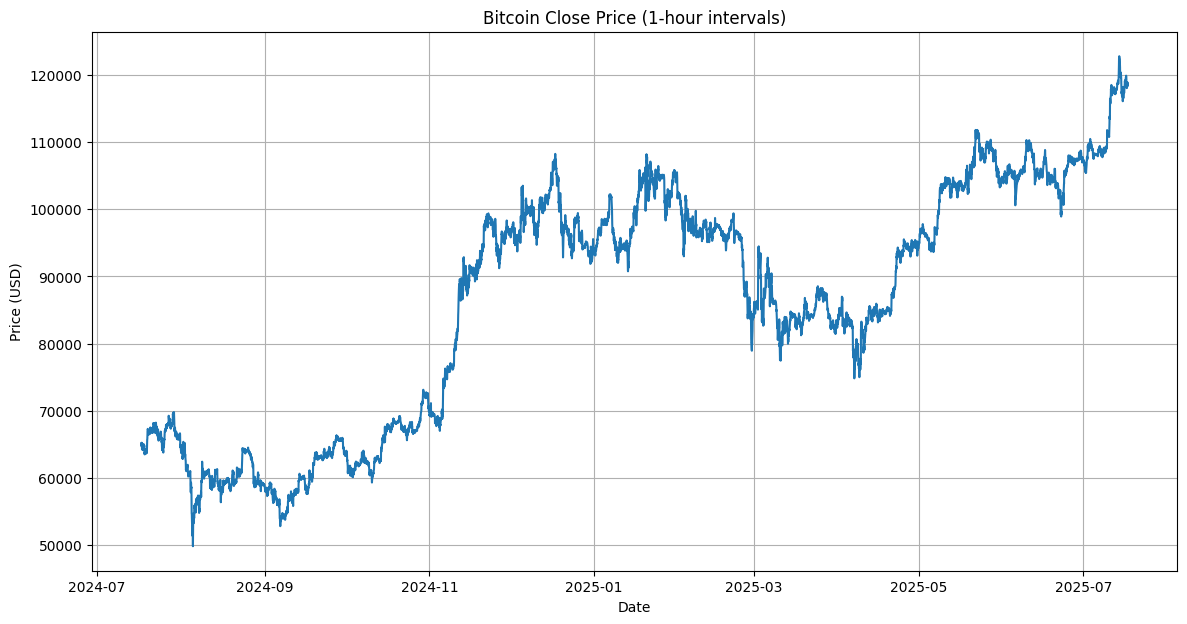

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data['Close'])
plt.title('Bitcoin Close Price (1-hour intervals)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

## 4. Prepare Data for ESN

In [5]:
def prepare_data(data, feature='Close', train_size=0.7):
    """
    Prepare data for ESN:
    1. Extract the feature (e.g., 'Close' price)
    2. Scale the data to [0, 1]
    3. Split into train and test sets
    """
    # Extract the feature
    series = data[feature].values.reshape(-1, 1)
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    series_scaled = scaler.fit_transform(series)
    
    # Split into train and test sets
    train_size = int(len(series_scaled) * train_size)
    train_data = series_scaled[:train_size]
    test_data = series_scaled[train_size:]
    
    return train_data, test_data, scaler

# Prepare data
train_data, test_data, scaler = prepare_data(btc_data, feature='Close', train_size=0.7)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (6132, 1)
Testing data shape: (2628, 1)


## 5. Create Input-Output Pairs for Time Series Prediction

In [6]:
def create_dataset(data, look_back=10, predict_ahead=1):
    """
    Create input-output pairs for time series prediction
    look_back: number of previous time steps to use as input
    predict_ahead: number of time steps ahead to predict
    """
    X, y = [], []
    for i in range(len(data) - look_back - predict_ahead + 1):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back + predict_ahead - 1, 0])
    return np.array(X), np.array(y)

# Set parameters
look_back = 24  # Use 24 hours of data to predict
predict_ahead = 1  # Predict 1 hour ahead

# Create input-output pairs
X_train, y_train = create_dataset(train_data, look_back, predict_ahead)
X_test, y_test = create_dataset(test_data, look_back, predict_ahead)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6108, 24)
y_train shape: (6108,)
X_test shape: (2604, 24)
y_test shape: (2604,)


## 6. Initialize ESN Parameters

In [7]:
# ESN parameters
N = 500  # Reservoir size
rho = 0.99  # Spectral radius
sigma = 0.1  # Input scaling
p = 1  # Reservoir connectivity
pin = 1  # Input connectivity
Two = 150  # Washout time

# Initialize ESN
esn = ESN(N=N, rho=rho, sigma=sigma, p=p, pin=pin)
print(f"ESN initialized with {N} neurons")

ESN initialized with 500 neurons


## 7. Run ESN on Training Data

In [8]:
# Run ESN on training data
print("Running ESN on training data...")
X_states_train = []
for i in range(len(X_train)):
    states = esn.run(X_train[i], f=np.tanh)
    X_states_train.append(states[-1])  # Take the last state
X_states_train = np.array(X_states_train)

# Add bias term
X_states_train_bias = np.hstack([X_states_train, np.ones((X_states_train.shape[0], 1))])
print(f"Reservoir states shape: {X_states_train.shape}")
print(f"Reservoir states with bias shape: {X_states_train_bias.shape}")

Running ESN on training data...
Reservoir states shape: (6108, 500)
Reservoir states with bias shape: (6108, 501)


## 8. Train Readout Weights

In [9]:
# Train readout weights using ridge regression (more stable than pinv)
ridge_param = 1e-6
I = ridge_param * np.eye(X_states_train_bias.shape[1])
wout = np.linalg.solve(X_states_train_bias.T @ X_states_train_bias + I, 
                       X_states_train_bias.T @ y_train.reshape(-1, 1))

print(f"Readout weights shape: {wout.shape}")

Readout weights shape: (501, 1)


## 9. Make Predictions on Test Data

In [10]:
# Make predictions on test data
print("Running ESN on test data...")
X_states_test = []
for i in range(len(X_test)):
    states = esn.run(X_test[i], f=np.tanh)
    X_states_test.append(states[-1])  # Take the last state
X_states_test = np.array(X_states_test)

# Add bias term
X_states_test_bias = np.hstack([X_states_test, np.ones((X_states_test.shape[0], 1))])

# Make predictions
y_pred = X_states_test_bias @ wout

# Calculate NRMSE
NRMSE = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2)) / np.std(y_test)
print(f"NRMSE: {NRMSE:.4f}")
if NRMSE < 0.2:
    print(f"NRMSE = {NRMSE:.4f} < 0.2 --> GOOD PERFORMANCE")
else:
    print(f"NRMSE = {NRMSE:.4f} > 0.2 --> PERFORMANCE CAN BE IMPROVED")

Running ESN on test data...
NRMSE: 0.0573
NRMSE = 0.0573 < 0.2 --> GOOD PERFORMANCE


## 10. Visualize Predictions

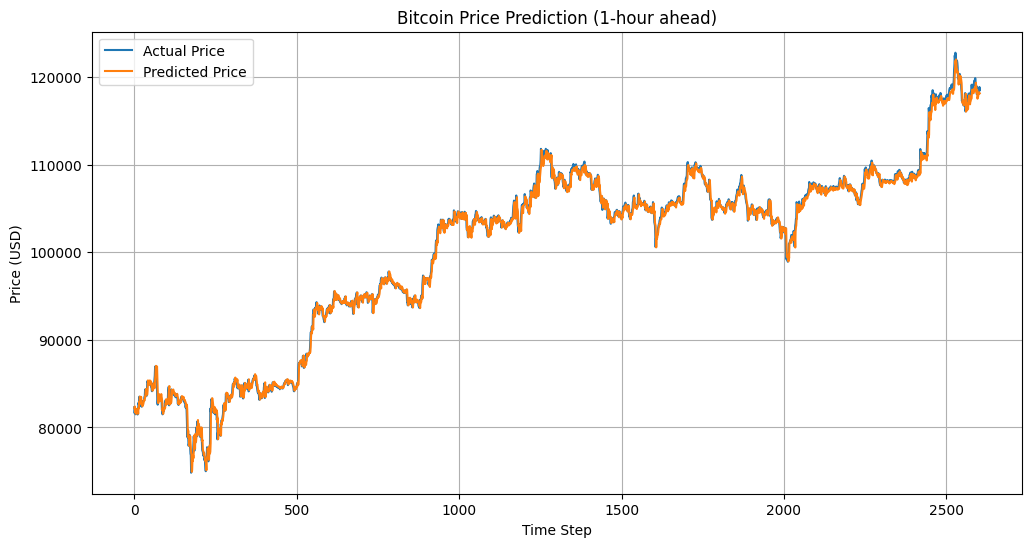

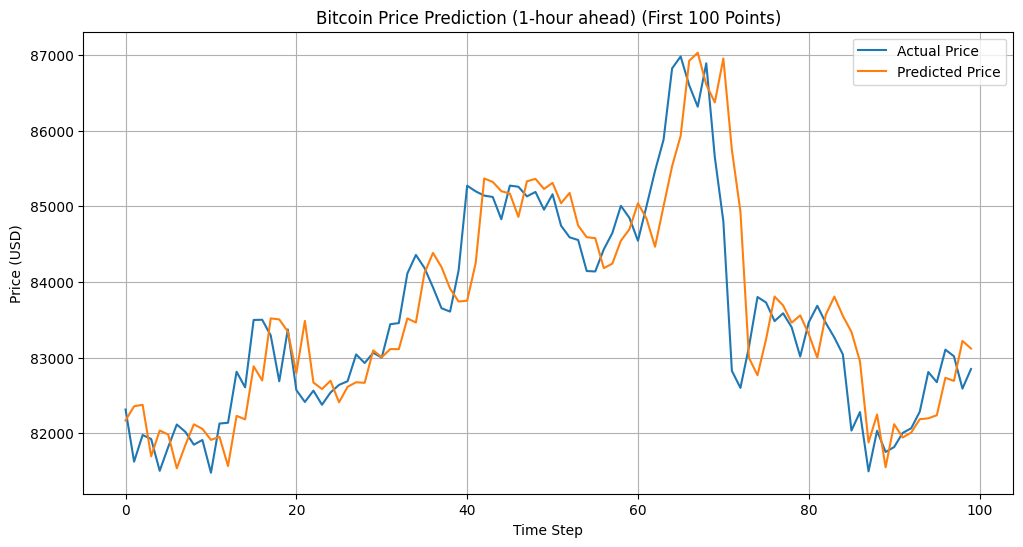

Mean Squared Error: $361320.45
Mean Absolute Error: $422.00


In [11]:
def plot_results(y_test, y_pred, scaler, title="Bitcoin Price Prediction"):
    """
    Plot the results:
    1. Inverse transform the scaled data
    2. Plot actual vs predicted prices
    """
    # Inverse transform
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Actual Price')
    plt.plot(y_pred_inv, label='Predicted Price')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the first 100 points for a closer look
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv[:100], label='Actual Price')
    plt.plot(y_pred_inv[:100], label='Predicted Price')
    plt.title(title + " (First 100 Points)")
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate and return error metrics
    mse = np.mean((y_test_inv - y_pred_inv) ** 2)
    mae = np.mean(np.abs(y_test_inv - y_pred_inv))
    return mse, mae

# Plot results
mse, mae = plot_results(y_test, y_pred.flatten(), scaler, title="Bitcoin Price Prediction (1-hour ahead)")
print(f"Mean Squared Error: ${mse:.2f}")
print(f"Mean Absolute Error: ${mae:.2f}")

## 11. Try Predicting Further Ahead (6 hours)

NRMSE (6-hour ahead): 0.1143


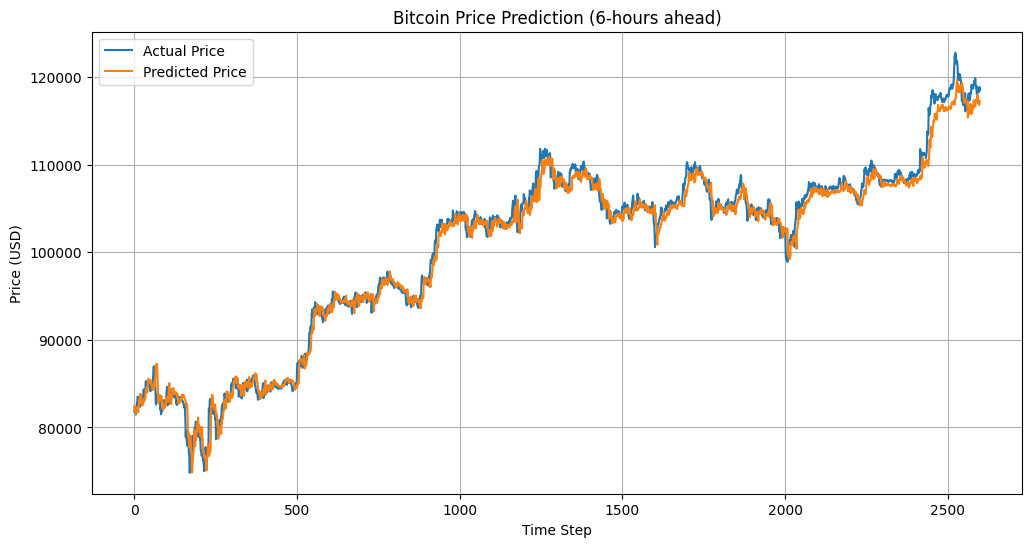

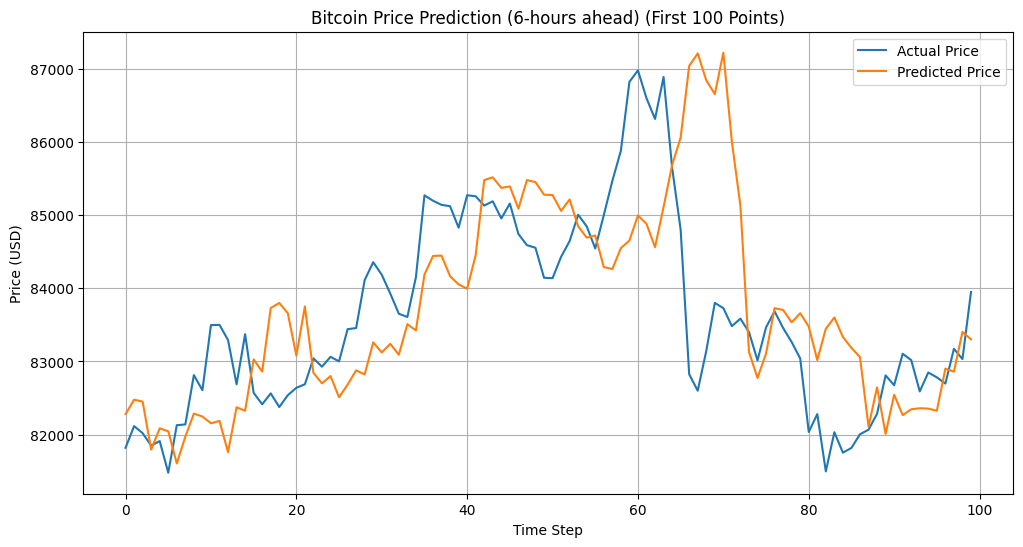

Mean Squared Error (6-hour ahead): $1430941.86
Mean Absolute Error (6-hour ahead): $858.03


In [12]:
# Try predicting further ahead
predict_ahead = 6  # Predict 6 hours ahead

# Create input-output pairs
X_train_6h, y_train_6h = create_dataset(train_data, look_back, predict_ahead)
X_test_6h, y_test_6h = create_dataset(test_data, look_back, predict_ahead)

# Run ESN on training data
X_states_train_6h = []
for i in range(len(X_train_6h)):
    states = esn.run(X_train_6h[i], f=np.tanh)
    X_states_train_6h.append(states[-1])
X_states_train_6h = np.array(X_states_train_6h)
X_states_train_bias_6h = np.hstack([X_states_train_6h, np.ones((X_states_train_6h.shape[0], 1))])

# Train readout weights
wout_6h = np.linalg.solve(X_states_train_bias_6h.T @ X_states_train_bias_6h + I, 
                         X_states_train_bias_6h.T @ y_train_6h.reshape(-1, 1))

# Make predictions on test data
X_states_test_6h = []
for i in range(len(X_test_6h)):
    states = esn.run(X_test_6h[i], f=np.tanh)
    X_states_test_6h.append(states[-1])
X_states_test_6h = np.array(X_states_test_6h)
X_states_test_bias_6h = np.hstack([X_states_test_6h, np.ones((X_states_test_6h.shape[0], 1))])
y_pred_6h = X_states_test_bias_6h @ wout_6h

# Calculate NRMSE
NRMSE_6h = np.sqrt(np.mean((y_pred_6h.flatten() - y_test_6h) ** 2)) / np.std(y_test_6h)
print(f"NRMSE (6-hour ahead): {NRMSE_6h:.4f}")

# Plot results
mse_6h, mae_6h = plot_results(y_test_6h, y_pred_6h.flatten(), scaler, title="Bitcoin Price Prediction (6-hours ahead)")
print(f"Mean Squared Error (6-hour ahead): ${mse_6h:.2f}")
print(f"Mean Absolute Error (6-hour ahead): ${mae_6h:.2f}")

## 12. Experiment with Different ESN Parameters

You can modify the ESN parameters to see how they affect the prediction performance. Here are some suggestions:

1. Increase/decrease reservoir size (N)
2. Adjust spectral radius (rho)
3. Change input scaling (sigma)
4. Modify reservoir connectivity (p)
5. Try different activation functions (f)
6. Experiment with different lookback periods

New ESN initialized with 800 neurons
NRMSE with new parameters: 0.0580
Original NRMSE: 0.0573
Improvement: -1.26%


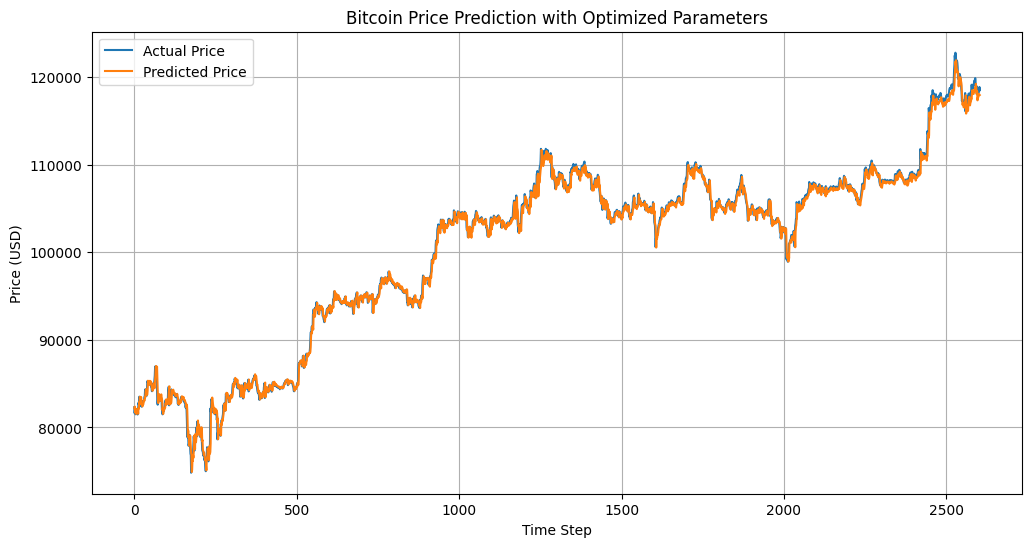

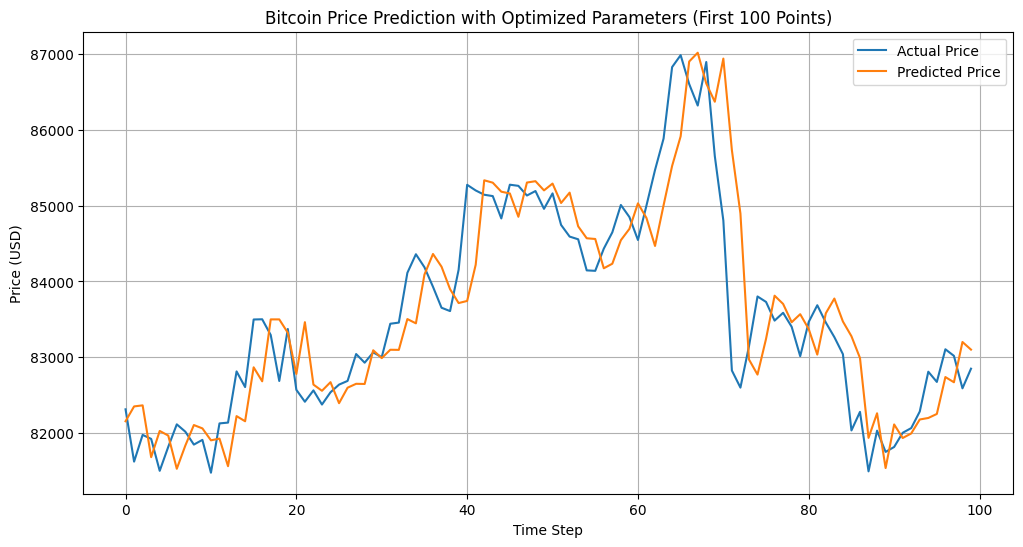

(np.float64(370449.0660405165), np.float64(430.407086787087))

In [13]:
# Example: Try a different reservoir size
N_new = 800
rho_new = 0.9
sigma_new = 0.1

# Initialize new ESN
esn_new = ESN(N=N_new, rho=rho_new, sigma=sigma_new, p=p, pin=pin)
print(f"New ESN initialized with {N_new} neurons")

# Run ESN on training data
X_states_train_new = []
for i in range(len(X_train)):
    states = esn_new.run(X_train[i], f=np.tanh)
    X_states_train_new.append(states[-1])
X_states_train_new = np.array(X_states_train_new)
X_states_train_bias_new = np.hstack([X_states_train_new, np.ones((X_states_train_new.shape[0], 1))])

# Train readout weights
I_new = ridge_param * np.eye(X_states_train_bias_new.shape[1])
wout_new = np.linalg.solve(X_states_train_bias_new.T @ X_states_train_bias_new + I_new, 
                          X_states_train_bias_new.T @ y_train.reshape(-1, 1))

# Make predictions on test data
X_states_test_new = []
for i in range(len(X_test)):
    states = esn_new.run(X_test[i], f=np.tanh)
    X_states_test_new.append(states[-1])
X_states_test_new = np.array(X_states_test_new)
X_states_test_bias_new = np.hstack([X_states_test_new, np.ones((X_states_test_new.shape[0], 1))])
y_pred_new = X_states_test_bias_new @ wout_new

# Calculate NRMSE
NRMSE_new = np.sqrt(np.mean((y_pred_new.flatten() - y_test) ** 2)) / np.std(y_test)
print(f"NRMSE with new parameters: {NRMSE_new:.4f}")

# Compare with original NRMSE
print(f"Original NRMSE: {NRMSE:.4f}")
print(f"Improvement: {(NRMSE - NRMSE_new) / NRMSE * 100:.2f}%")

#=================== test ====================
# def shift_array(arr, shift):
#     """Décale un tableau 2D ou 1D vers la droite ou la gauche."""
#     if shift > 0:
#         return arr[shift:]
#     elif shift < 0:
#         return arr[:shift]
#     else:
#         return arr

# shift = -2  # nombre de pas de décalage
# yt_shifted = shift_array(y_test, shift)
# yp_shifted = shift_array(y_pred, -shift)
#================================================
# Plot results
#plot_results(yt_shifted, yp_shifted, scaler, title="Bitcoin Price Prediction with Optimized Parameters")
plot_results(y_test, y_pred_new.flatten(), scaler, title="Bitcoin Price Prediction with Optimized Parameters")

##  13. Search Grid 

In [15]:
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=14):

    rhos = np.arange(0.1, 1.51, 0.3)
    mus = np.arange(0.5, 10.01, 0.9)
    sigmas = np.arange(0.1, 0.51, 0.1)
    p, pin = 1, 1
    ridge_param = 1e-6  # tu peux ajuster ce paramètre de régularisation

    nrmses = np.zeros((len(rhos), len(mus), len(sigmas)))

    for i, rho in enumerate(rhos):
        for j, mu in enumerate(mus):
            for k, sigma in enumerate(sigmas):
                # Initialisation de l'ESN
                esn = ESN(N=N, rho=rho, sigma=sigma, p=p, pin=pin)
                
                # Entraînement
                X_states_train = []
                for n in range(len(X_train)):
                    u = mu + sigma * X_train[n]  # injection biaisée et rescalée
                    states = esn.run(u, f=np.tanh)
                    X_states_train.append(states[-1])
                X_states_train = np.array(X_states_train)
                X_states_train_bias = np.hstack([X_states_train, np.ones((X_states_train.shape[0], 1))])
                
                # Apprentissage du readout
                I = ridge_param * np.eye(X_states_train_bias.shape[1])
                wout = np.linalg.solve(X_states_train_bias.T @ X_states_train_bias + I,
                                    X_states_train_bias.T @ y_train.reshape(-1, 1))
                
                # Prédiction
                X_states_test = []
                for n in range(len(X_test)):
                    u = mu + sigma * X_test[n]  # même transformation que pour l'entraînement
                    states = esn.run(u, f=np.tanh)
                    X_states_test.append(states[-1])
                X_states_test = np.array(X_states_test)
                X_states_test_bias = np.hstack([X_states_test, np.ones((X_states_test.shape[0], 1))])
                y_pred = X_states_test_bias @ wout

                # Évaluation NRMSE
                nrmse = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2)) / np.std(y_test)
                nrmses[i, j, k] = nrmse
                print(f"[{i},{j},{k}] rho={rho:.2f}, mu={mu:.2f}, sigma={sigma:.2f} -> NRMSE={nrmse:.4f}")

    # Recherche des meilleurs paramètres
    index = np.unravel_index(np.argmin(nrmses), nrmses.shape)
    rho_opt, mu_opt, sigma_opt = rhos[index[0]], mus[index[1]], sigmas[index[2]]
    print("\nMeilleurs hyperparamètres trouvés :")
    print(f"rho = {rho_opt:.2f}, mu = {mu_opt:.2f}, sigma = {sigma_opt:.2f}")
    print(f"NRMSE = {np.min(nrmses):.4f}")



[0,0,0] rho=0.10, mu=0.50, sigma=0.10 -> NRMSE=0.0550
[0,0,1] rho=0.10, mu=0.50, sigma=0.20 -> NRMSE=0.0555
[0,0,2] rho=0.10, mu=0.50, sigma=0.30 -> NRMSE=0.0557
[0,0,3] rho=0.10, mu=0.50, sigma=0.40 -> NRMSE=0.0557
[0,0,4] rho=0.10, mu=0.50, sigma=0.50 -> NRMSE=0.0569
[0,1,0] rho=0.10, mu=1.40, sigma=0.10 -> NRMSE=0.0550
[0,1,1] rho=0.10, mu=1.40, sigma=0.20 -> NRMSE=0.0556
[0,1,2] rho=0.10, mu=1.40, sigma=0.30 -> NRMSE=0.0556
[0,1,3] rho=0.10, mu=1.40, sigma=0.40 -> NRMSE=0.0561
[0,1,4] rho=0.10, mu=1.40, sigma=0.50 -> NRMSE=0.0581
[0,2,0] rho=0.10, mu=2.30, sigma=0.10 -> NRMSE=0.0550
[0,2,1] rho=0.10, mu=2.30, sigma=0.20 -> NRMSE=0.0556
[0,2,2] rho=0.10, mu=2.30, sigma=0.30 -> NRMSE=0.0556
[0,2,3] rho=0.10, mu=2.30, sigma=0.40 -> NRMSE=0.0564
[0,2,4] rho=0.10, mu=2.30, sigma=0.50 -> NRMSE=0.0580
[0,3,0] rho=0.10, mu=3.20, sigma=0.10 -> NRMSE=0.0551
[0,3,1] rho=0.10, mu=3.20, sigma=0.20 -> NRMSE=0.0555
[0,3,2] rho=0.10, mu=3.20, sigma=0.30 -> NRMSE=0.0556
[0,3,3] rho=0.10, mu=3.20, s

KeyboardInterrupt: 

La grid search est très longue et ne donne pas des resultats extrement differents ! Voir avec un MCMC.